<a href="https://colab.research.google.com/github/threegenie/sentiment_project/blob/main/playstore_review_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install konlpy

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

# https://pinkwink.kr/1255 / https://teddylee777.github.io/colab/colab-korean 한글 문제 대응 참고

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [7]:
fl = pd.read_csv('Crawling_data flo.csv')
dg = pd.read_csv('Crawling_data_dangeun.csv')

In [8]:
fl.shape, dg.shape

((200, 4), (200, 4))

In [9]:
fl = fl.fillna(0)
dg = dg.fillna(0)

In [10]:
fl.head()

,DATE,STAR,LIKE,REVIEW
0,2021년 5월 28일,별표 5개 만점에 4개를 받았습니다.,22.0,다 좋아요! 만족하면서 잘 쓰고 있습니다. 그런데 왜 한 리스트에 같은 곡이 중복으...
1,2021년 5월 28일,별표 5개 만점에 4개를 받았습니다.,13.0,다 좋은데 아쉬움점 몇가지.. 1.오프라인 재생 이용권에서 저장경로를 내부저장소 말...
2,2021년 5월 31일,별표 5개 만점에 5개를 받았습니다.,6.0,안녕하세요! 저는 플로를 사용한지 약 1년이 되어가는 플로유저입니다!🎶 살짝 아쉬운...
3,2021년 5월 29일,별표 5개 만점에 4개를 받았습니다.,1.0,장시간 운전하며 이용하는데 음악 리스트 젤 오른쪽 스크롤바가 눈에 너무 안뛰어 찾기...
4,2021년 5월 31일,별표 5개 만점에 3개를 받았습니다.,0.0,플로 사용한지 꽤 됐는데 나름 만족하면서 쓰고있습니다. 다만 노래 가사들이 없는것도...


In [11]:
dg.head()

,DATE,STAR,LIKE,REVIEW
0,2021년 5월 31일,별표 5개 만점에 1개를 받았습니다.,9.0,아니알림문자가안와서게속했는데20초뒤에누르라고하네요그럼전20초기다리는개입니까?그리고하...
1,2021년 5월 29일,별표 5개 만점에 3개를 받았습니다.,35.0,"앱은 정말 편리해서 잘 사용하고 있습니다~ㅎㅎ 다만, 채팅방 내용이 수시로 사라지기..."
2,2021년 6월 1일,별표 5개 만점에 1개를 받았습니다.,5.0,"어느 순간부터 검색시 엉뚱한 화면, 고객센터에 문의하기 누르면 백지 화면, 지역 광..."
3,2021년 5월 31일,별표 5개 만점에 3개를 받았습니다.,7.0,+관리자 답변보면 알겠지만 가격안깎아준다고 거짓후기 남발로 이용정지 되어도 구제 방...
4,2021년 5월 26일,별표 5개 만점에 1개를 받았습니다.,17.0,알람이 잘 올때도 있고 안올 때도 있네요. 로그아웃 해보거나 삭제후 재 설치를 해도...


#### 중복 데이터가 있다면 제거

In [12]:
fl.drop_duplicates('REVIEW',keep='first')
fl.shape

(200, 4)

In [13]:
dg.drop_duplicates('REVIEW',keep='first')
dg.shape

(200, 4)

#### 데이터 치환

In [14]:
def processing(df):
  mapping = {'별표 5개 만점에 1개를 받았습니다.':1,'별표 5개 만점에 2개를 받았습니다.':2,'별표 5개 만점에 3개를 받았습니다.':3,'별표 5개 만점에 4개를 받았습니다.':4,'별표 5개 만점에 5개를 받았습니다.':5}
  df['STAR'] = df['STAR'].replace(mapping)

processing(fl)
processing(dg)

#### 별3개 데이터 제거

In [15]:
three = fl[fl['STAR']==3].index
fl = fl.drop(three)
fl.shape

(154, 4)

In [16]:
three = dg[dg['STAR']==3].index
dg = dg.drop(three)
dg.shape

(177, 4)

#### 별점으로 라벨링

In [17]:
def star_evaluate(rating):
  if rating >=4:
    return 1
  else:
    return 0

fl['LABEL'] = fl['STAR'].apply(star_evaluate)
dg['LABEL'] = dg['STAR'].apply(star_evaluate)

In [18]:
fl['LABEL'].value_counts()

1    92
0    62
Name: LABEL, dtype: int64

In [19]:
dg['LABEL'].value_counts()

1    99
0    78
Name: LABEL, dtype: int64

#### 데이터 정제

In [20]:
fl['REVIEW'] = fl['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
fl['REVIEW'].replace('', np.nan, inplace=True)

In [21]:
dg['REVIEW'] = dg['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
dg['REVIEW'].replace('', np.nan, inplace=True)

In [22]:
fl.head()

,DATE,STAR,LIKE,REVIEW,LABEL
0,2021년 5월 28일,4,22.0,다 좋아요 만족하면서 잘 쓰고 있습니다 그런데 왜 한 리스트에 같은 곡이 중복으로 ...,1
1,2021년 5월 28일,4,13.0,다 좋은데 아쉬움점 몇가지 오프라인 재생 이용권에서 저장경로를 내부저장소 말고도 마...,1
2,2021년 5월 31일,5,6.0,안녕하세요 저는 플로를 사용한지 약 년이 되어가는 플로유저입니다 살짝 아쉬운 점이라...,1
3,2021년 5월 29일,4,1.0,장시간 운전하며 이용하는데 음악 리스트 젤 오른쪽 스크롤바가 눈에 너무 안뛰어 찾기...,1
6,2021년 5월 4일,1,45.0,음질이 아쉽네요 개선이 시급합니다 차에서 들을때 멜론 스포티파이에서는 굉장히 선명하...,0


#### 토큰화 - Okt

In [23]:
from konlpy.tag import Okt
okt = Okt()

In [24]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [25]:
fl['TOKEN'] = fl['REVIEW'].apply(okt.morphs)
fl['TOKEN'] = fl['TOKEN'].apply(lambda x: [item for item in x if item not in stopwords])

In [26]:
dg['TOKEN'] = dg['REVIEW'].apply(okt.morphs)
dg['TOKEN'] = dg['TOKEN'].apply(lambda x: [item for item in x if item not in stopwords])

#### 단어 빈도에 따른 시각화 - Counter, Wordcloud 패키지 이용

> FLO

In [27]:
negative_words = np.hstack(fl[fl.LABEL == 0]['TOKEN'].values)
positive_words = np.hstack(fl[fl.LABEL == 1]['TOKEN'].values)

In [28]:
nw = Counter(negative_words)
print(nw.most_common(20))

[('재생', 29), ('곡', 21), ('안', 19), ('앱', 19), ('하고', 17), ('로', 17), ('리스트', 17), ('노래', 16), ('다시', 16), ('에서', 15), ('음악', 14), ('왜', 14), ('잘', 13), ('플레이', 13), ('플로', 12), ('해도', 12), ('으로', 12), ('인터넷', 12), ('결제', 12), ('해지', 12)]


In [29]:
nwc = nw.most_common(15)

{'재생': 29, '곡': 21, '안': 19, '앱': 19, '하고': 17, '로': 17, '리스트': 17, '노래': 16, '다시': 16, '에서': 15, '음악': 14, '왜': 14, '잘': 13, '플레이': 13, '플로': 12}


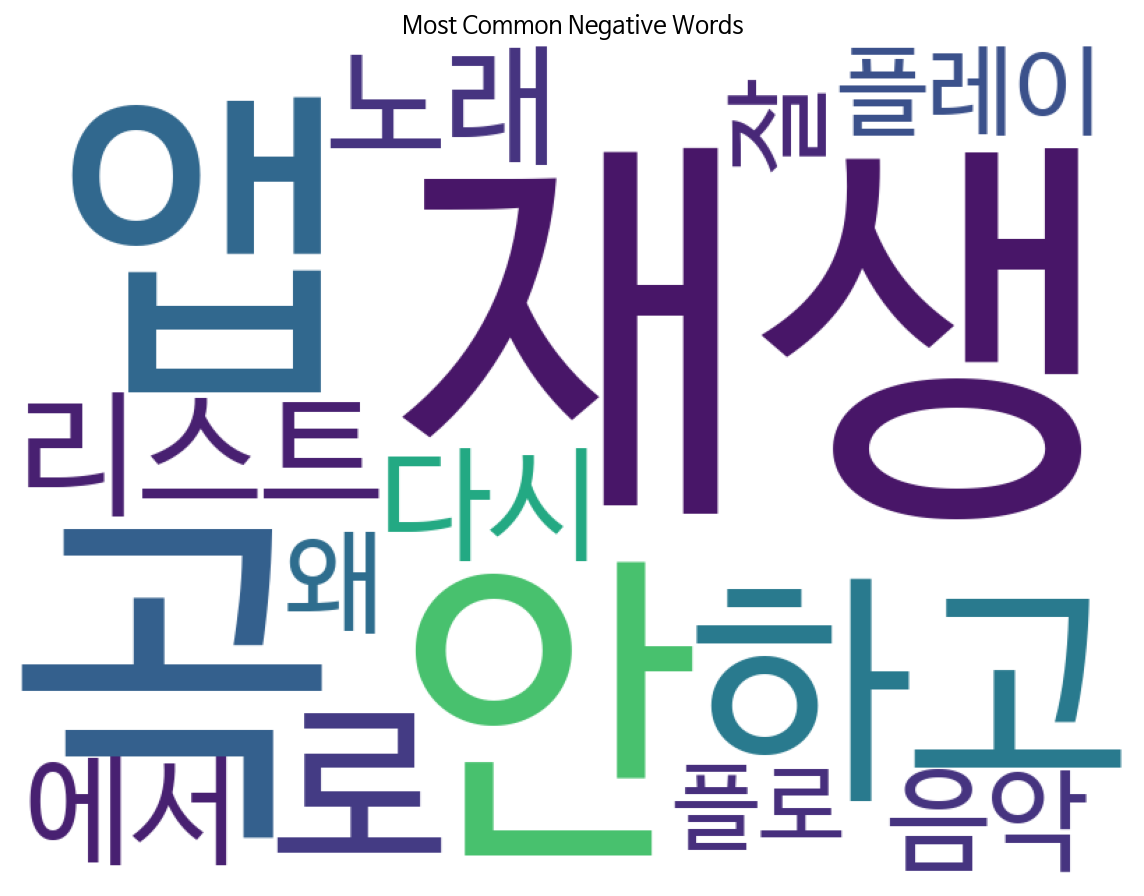

In [30]:
from wordcloud import WordCloud

#wordCloud생성
#한글꺠지는 문제 해결하기위해 font_path 지정
negative_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(nwc))
cloud = negative_word_cloud.generate_from_frequencies(dict(nwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Negative Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [31]:
pw = Counter(positive_words)
print(pw.most_common(20))

[('노래', 47), ('곡', 40), ('플로', 39), ('재생', 36), ('너무', 36), ('기능', 33), ('잘', 31), ('리스트', 29), ('에서', 29), ('음악', 29), ('앱', 28), ('으로', 24), ('사용', 21), ('수', 21), ('때', 20), ('로', 18), ('있는', 18), ('할', 17), ('안', 17), ('만', 16)]


In [32]:
pwc = pw.most_common(15)

{'노래': 47, '곡': 40, '플로': 39, '재생': 36, '너무': 36, '기능': 33, '잘': 31, '리스트': 29, '에서': 29, '음악': 29, '앱': 28, '으로': 24, '사용': 21, '수': 21, '때': 20}


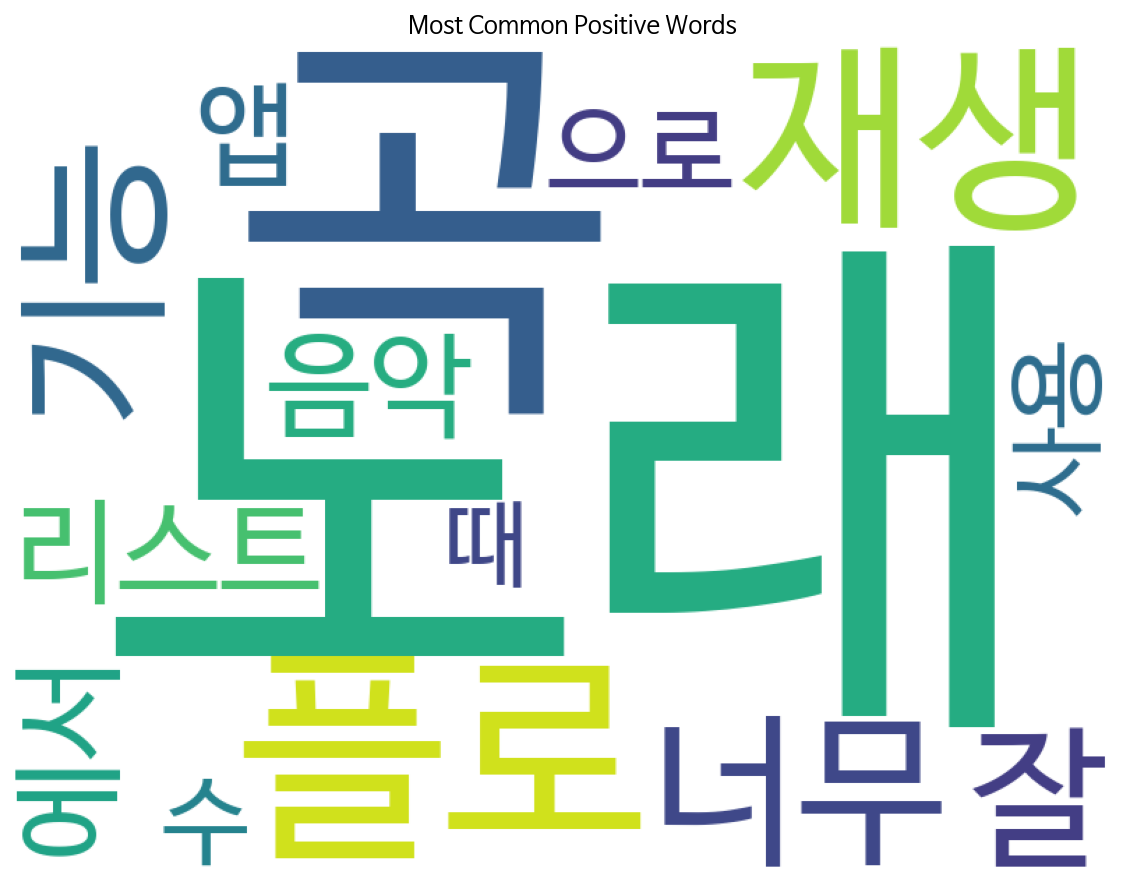

In [33]:
positive_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(pwc))
cloud = positive_word_cloud.generate_from_frequencies(dict(pwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Positive Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

> 당근

In [34]:
negative_words = np.hstack(dg[dg.LABEL == 0]['TOKEN'].values)
positive_words = np.hstack(dg[dg.LABEL == 1]['TOKEN'].values)

In [35]:
nw = Counter(negative_words)
print(nw.most_common(20))

[('안', 51), ('당근', 42), ('거래', 40), ('마켓', 35), ('로', 34), ('으로', 32), ('사람', 32), ('하고', 29), ('고객', 28), ('센터', 27), ('앱', 25), ('채팅', 25), ('매너', 25), ('만', 24), ('에서', 23), ('인증', 22), ('다시', 21), ('판매', 21), ('글', 21), ('비', 21)]


In [36]:
nwc = nw.most_common(15)

{'안': 51, '당근': 42, '거래': 40, '마켓': 35, '로': 34, '으로': 32, '사람': 32, '하고': 29, '고객': 28, '센터': 27, '앱': 25, '채팅': 25, '매너': 25, '만': 24, '에서': 23}


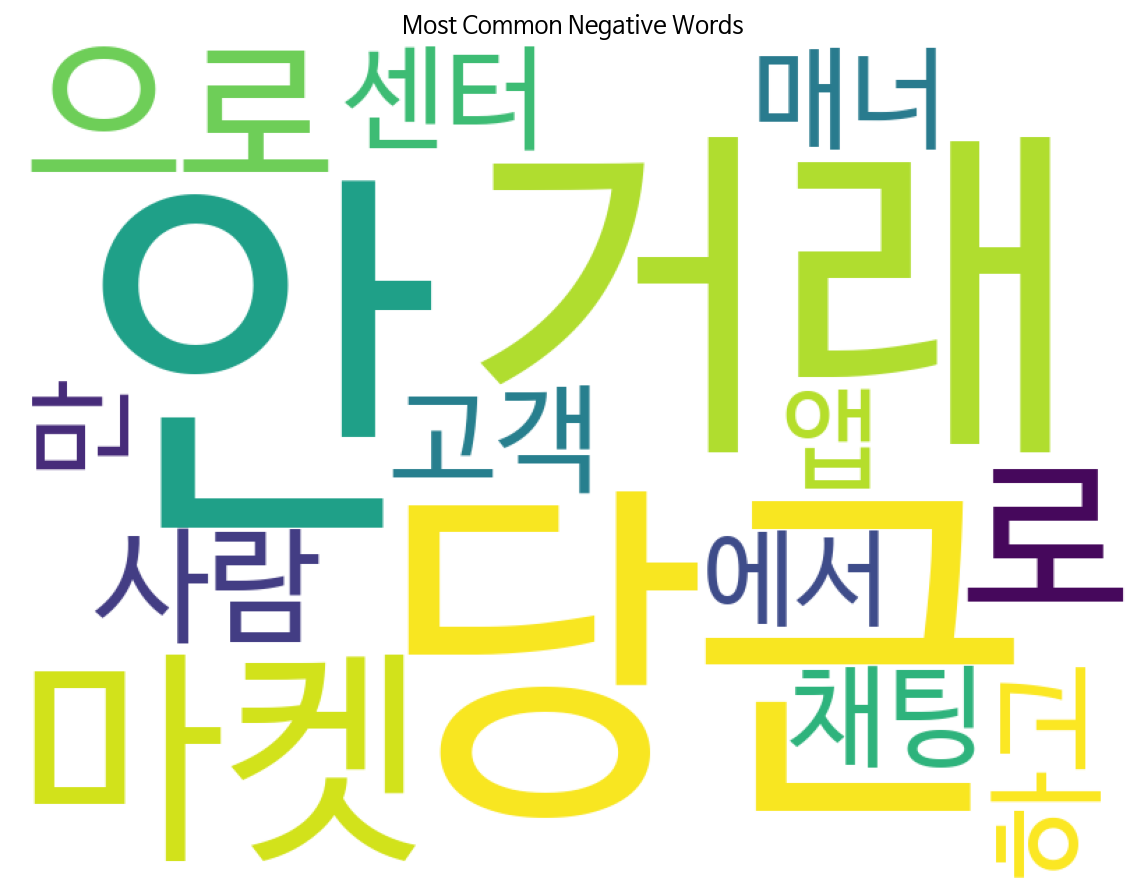

In [37]:
from wordcloud import WordCloud

#wordCloud생성
#한글꺠지는 문제 해결하기위해 font_path 지정
negative_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(nwc))
cloud = negative_word_cloud.generate_from_frequencies(dict(nwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Negative Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [38]:
pw = Counter(positive_words)
print(pw.most_common(20))

[('거래', 61), ('물건', 52), ('로', 38), ('하고', 36), ('것', 32), ('앱', 31), ('당근', 31), ('잘', 30), ('으로', 29), ('알림', 29), ('사용', 29), ('마켓', 28), ('수', 28), ('에서', 26), ('할', 26), ('좋은', 24), ('당', 22), ('근', 21), ('채팅', 21), ('때', 20)]


In [39]:
pwc = pw.most_common(15)

{'거래': 61, '물건': 52, '로': 38, '하고': 36, '것': 32, '앱': 31, '당근': 31, '잘': 30, '으로': 29, '알림': 29, '사용': 29, '마켓': 28, '수': 28, '에서': 26, '할': 26}


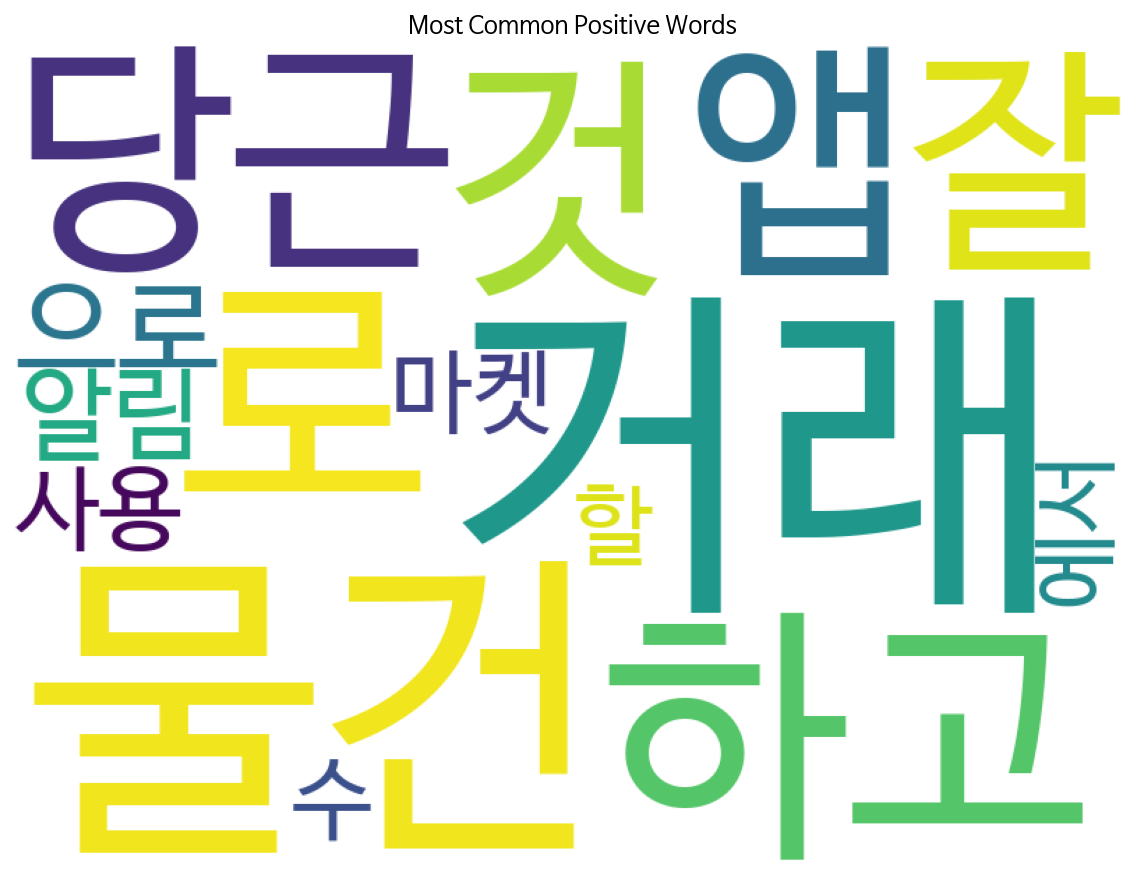

In [40]:
positive_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(pwc))
cloud = positive_word_cloud.generate_from_frequencies(dict(pwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Positive Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

#### 데이터에 정수 인코딩 + Model 

> FLO

In [41]:
X_train = fl['TOKEN']
y_train = fl['LABEL']

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1839
등장 빈도가 1번 이하인 희귀 단어의 수: 1182
단어 집합에서 희귀 단어의 비율: 64.27406199021208
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 24.127372933251685


In [44]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 659


In [45]:
X_train = tokenizer.texts_to_sequences(X_train)

In [46]:
max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train, maxlen = max_len)

In [47]:
flo_model = Sequential()
flo_model.add(Embedding(vocab_size, 100))
flo_model.add(GRU(128))
flo_model.add(Dense(1, activation='relu'))

In [48]:
flo_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         65900     
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 154,349
Trainable params: 154,349
Non-trainable params: 0
_________________________________________________________________


In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [51]:
flo_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = flo_model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=10)

Epoch 1/15


InvalidArgumentError: ignored

> 당근

In [ ]:
X_train = dg['TOKEN']
y_train = dg['LABEL']

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
max_len = 80 #Padding 80으로
fX_train = pad_sequences(fX_train, maxlen = max_len)

dX_train = pad_sequences(dX_train, maxlen = max_len)